In [7]:
import os
import time
import copy
import json
import numpy as np
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt     
import torchvision.utils as vutils 

from torch.utils.data import Subset

from torch.utils.data import ConcatDataset #unseen data를 통해서 언러닝 재학습에서 사용.
from torch.utils.data import TensorDataset

from options import args_parser
from update import LocalUpdate, test_inference
from models import CNNMnist,ResNet18, CNNCifar, Generator, Discriminator, generate_images, filter_images
from utils import get_dataset, average_weights, exp_details, create_poisoned_dataset
from unlearn import (
    train_generator_ungan,
    train_gd_ungan,
    train_gd_ungan_with_unseen,
    SyntheticImageDataset, 
    partition_synthetic_data_iid,
    partition_synthetic_data_dirichlet,
    get_synthetic_subset
)
from evaluate_mia import evaluate_mia, comprehensive_evaluation, evaluate_synthetic_classification_accuracy, evaluate_classification_accuracy

# 교수님 전달사항 반영

1. 데이터셋을 cifar-10으로 진행할 것 --> MNIST는 너무 단순해서 GAN 성능 평가가 어려움
2. Non-IID 환경으로 진행할 것. 이때 뒤리끌레 분포를 사용할 것
3. GAN의 성능 향상이 필요함
4. 데이터 세트의 수를 맞추자. unseen을 1000개 썼다면 unseen + forget도 1000개 이런 식으로!
5. unseen 데이터와 비교해야 함. 즉 합성 데이터가 unseen 데이터와 비슷한 성능을 보이는가? 
6. 기존 연합학습에서 사용한 전체 데이터, retain 데이터, forget 데이터, 생성한 데이터 세트에 대한 분류 성능을 비교하는 걸 추가


==> 즉, 우리는 동일한 조건에서 모든 데이터를 평가해야하고 같은 모델을 사용해야함. Unseen과 생성 데이터의 품질 격차가 적을수록 좋음! 

In [8]:
def visualize_real_vs_generated_with_filtering(generator, discriminator, dataset, forget_idxs, 
                                             z_dim=100, device='cpu', threshold=0.5, num_samples=16):
    """
    실제 이미지, 생성된 이미지, 필터링된 이미지를 모두 비교 시각화
    """
    # 실제 이미지 샘플링
    real_images = []
    sample_idxs = np.random.choice(forget_idxs, min(num_samples, len(forget_idxs)), replace=False)
    
    for idx in sample_idxs:
        img, _ = dataset[idx]
        real_images.append(img)
    
    real_images = torch.stack(real_images)
    
    # 더 많은 이미지를 생성해서 필터링 효과를 보여주기
    num_generate = num_samples * 2  # 2배 생성해서 필터링
    
    # 생성된 이미지
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        # 기존: noise = torch.randn(num_generate, z_dim, device=device)
        # 수정: DCGAN 형식으로 (batch, z_dim, 1, 1)
        noise = torch.randn(num_generate, z_dim, 1, 1, device=device)
        
        generated_images = generator(noise)
        
        # Discriminator로 품질 평가
        d_scores = discriminator(generated_images.to(device))
        
        # CPU로 이동하고 정규화
        generated_images = generated_images.cpu()
        generated_images = torch.clamp(generated_images, -1, 1)
        generated_images = (generated_images + 1) / 2
        
        # 필터링 (threshold 이상만 선택)
        d_scores = d_scores.cpu().squeeze()
        high_quality_mask = d_scores > threshold
        
        if high_quality_mask.sum() > 0:
            filtered_images = generated_images[high_quality_mask]
            filtered_scores = d_scores[high_quality_mask]
            # 상위 num_samples개만 선택
            if len(filtered_images) > num_samples:
                top_indices = torch.topk(filtered_scores, num_samples)[1]
                filtered_images = filtered_images[top_indices]
        else:
            # 필터링된 이미지가 없으면 상위 점수 이미지들 선택
            top_indices = torch.topk(d_scores, num_samples)[1]
            filtered_images = generated_images[top_indices]
    
    # 실제 이미지 정규화
    if real_images.min() < 0:  # 이미 정규화된 경우
        real_images = (real_images + 1) / 2
    elif real_images.max() > 1:  # 0-255 범위
        real_images = real_images / 255.0
    
    # 3행으로 비교 시각화
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))
    
    # 실제 이미지
    real_grid = vutils.make_grid(real_images, nrow=8, normalize=False, padding=2)
    real_grid_np = real_grid.permute(1, 2, 0).numpy()
    ax1.imshow(real_grid_np, cmap='gray' if real_images.shape[1] == 1 else None)
    ax1.set_title('Real Images (Forget Set)', fontsize=14)
    ax1.axis('off')
    
    # 모든 생성된 이미지 (처음 num_samples개)
    all_gen_grid = vutils.make_grid(generated_images[:num_samples], nrow=8, normalize=False, padding=2)
    all_gen_grid_np = all_gen_grid.permute(1, 2, 0).numpy()
    ax2.imshow(all_gen_grid_np, cmap='gray' if generated_images.shape[1] == 1 else None)
    ax2.set_title('All Generated Images', fontsize=14)
    ax2.axis('off')
    
    # 필터링된 고품질 이미지
    filtered_grid = vutils.make_grid(filtered_images, nrow=8, normalize=False, padding=2)
    filtered_grid_np = filtered_grid.permute(1, 2, 0).numpy()
    ax3.imshow(filtered_grid_np, cmap='gray' if filtered_images.shape[1] == 1 else None)
    ax3.set_title(f'High-Quality Filtered Images (D-score > {threshold})', fontsize=14)
    ax3.axis('off')
    
    plt.tight_layout()
    plt.savefig('./real_vs_generated_filtered.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discriminator 점수 통계 출력
    print(f"Discriminator Scores - Mean: {d_scores.mean():.3f}, Std: {d_scores.std():.3f}")
    print(f"High-quality images (>{threshold}): {high_quality_mask.sum().item()}/{len(d_scores)}")
    print("Comparison image saved to: ./real_vs_generated_filtered.png")


# visualize_discriminator_scores 함수도 동일하게 수정
def visualize_discriminator_scores(generator, discriminator, z_dim=100, device='cpu', num_samples=100):
    """
    Discriminator 점수 분포를 히스토그램으로 시각화
    """
    generator.eval()
    discriminator.eval()
    
    with torch.no_grad():
        # ========== 여기도 수정! ==========
        # 기존: noise = torch.randn(num_samples, z_dim, device=device)
        # 수정: DCGAN 형식으로
        noise = torch.randn(num_samples, z_dim, 1, 1, device=device)
        
        generated_images = generator(noise)
        d_scores = discriminator(generated_images).cpu().squeeze().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.hist(d_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Discriminator Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Discriminator Scores for Generated Images')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('./discriminator_scores_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Discriminator scores - Min: {d_scores.min():.3f}, Max: {d_scores.max():.3f}")
    print(f"Mean: {d_scores.mean():.3f}, Std: {d_scores.std():.3f}")
    print("Discriminator scores distribution saved to: ./discriminator_scores_distribution.png")

In [9]:
def move_dataset_to_device(dataset, device):
    images = []
    labels = []
    for x, y in dataset:
        images.append(x.to(device))
        labels.append(torch.tensor(y).to(device))
    return TensorDataset(torch.stack(images), torch.stack(labels))


def add_backdoor_trigger(x):
    x_bd = x.clone()
    x_bd[:, 25:28, 25:28] = 0.9
    return x_bd

def evaluate_backdoor_asr(model, dataset, target_label, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            # 백도어 트리거 삽입
            x_bd = add_backdoor_trigger(x).to(device)
            x_bd = x_bd.unsqueeze(0)  # 배치 차원 추가

            output = model(x_bd)
            pred = output.argmax(dim=1).item()

            total += 1
            if pred == target_label:
                correct += 1

    asr = correct / total
    return asr

def select_model(args, train_dataset):
    if args.model == 'cnn':
        if args.dataset == 'cifar':
            return CNNCifar(args=args)  # CIFAR-10용 CNN 추가 필요
        else:
            return CNNMnist(args=args)  # MNIST용 CNN
    elif args.model == 'resnet':
        return ResNet18(num_classes=args.num_classes)  # CIFAR-10용 ResNet
    else:
        raise NotImplementedError


# 전체 플로우

## 1. 데이터 준비
CIFAR-10 데이터셋
Training Set (55,000) → Non-IID로 10개 클라이언트에게 분배

Test Set (10,000) → 성능 평가용

Unseen Set (5,000) → 모델이 학습하지 않은 깨끗한 데이터

## 2. 초기 연합학습 + 언러닝 요청 처리
클라이언트 0~9 모두 참여

중간에 클라이언트 0이 언러닝 요청 📢

서버: "클라이언트 0 제외하고 계속 진행"
    
결과: forget 데이터 영향이 제거된 모델 (하지만 성능 하락하는 문제)

## 3. GAN으로 연합학습 + 언러닝 요청 처리
목표: forget 데이터를 고품질로 대체할 합성 데이터 생성

Generator 훈련: forget 데이터 특징 학습

Discriminator 훈련: 진짜/가짜 구분

Unseen 데이터 활용: 더 자연스러운 생성

결과: forget_size만큼의 고품질 합성 데이터

## 4. 성능 복구 연합학습
데이터 구성:

Retain Set (기존 클라이언트 1~9의 데이터)

Synthetic Set (생성된 합성 데이터)

연합학습 참여자:

클라이언트 1~9 (forget 클라이언트 0은 여전히 제외)

각 클라이언트: 기존 retain 데이터 + 할당된 합성 데이터

결과: 성능이 복구된 언러닝 모델

## 5. 성능 비교평가
4가지 데이터셋으로 성능 측정:

Original Test Set: 전체적인 모델 성능

Retain Set: 남아있는 데이터 성능 

Forget Set: 잊혀진 데이터 성능 

Synthetic Set: 생성 데이터 품질

핵심: Synthetic vs Unseen 성능 비교

In [10]:
def main():
    start_time = time.time()
    args = args_parser()
    device = 'cuda' if args.gpu and torch.cuda.is_available() else 'cpu'

    exp_details(args)

    # ===================== 1. 데이터셋 로딩 및 초기화 =====================
    train_dataset, test_dataset, unseen_dataset, user_groups = get_dataset(args)
    

    # full_dataset, user_groups = create_poisoned_dataset(train_dataset, user_groups, args,
    #                                                     malicious_client=0,
    #                                                     target_label=6,
    #                                                     poison_ratio=0.8)

    full_dataset = train_dataset  # create_poisoned_dataset 제거



    global_model = select_model(args, full_dataset).to(device)
    global_model.train()


    if args.dataset == 'cifar':
        generator = Generator(z_dim=args.z_dim, img_shape=(3, 32, 32)).to(device)      # 64x64로 변경
        discriminator = Discriminator(img_shape=(3, 32, 32)).to(device)                # 64x64로 변경
    else:
        generator = Generator(z_dim=args.z_dim).to(device)
        discriminator = Discriminator().to(device)


    # DCGAN 가중치 초기화 적용
    from models import weights_init
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    print(f"[DCGAN] Generator initialized:")
    print(f"[DCGAN] - Parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"[DCGAN] Discriminator initialized:")
    print(f"[DCGAN] - Parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


    global_weights = global_model.state_dict()
    train_loss, train_accuracy = [], []

    forget_client = 0
    forget_idxs = user_groups[forget_client]
    retain_idxs = [i for i in range(len(train_dataset)) if i not in forget_idxs]
    test_idxs = np.random.choice(len(test_dataset), len(forget_idxs), replace=False)

    # 데이터 수량 균형 - unseen 데이터 준비
    forget_size = len(forget_idxs)
    unseen_idxs = np.random.choice(len(unseen_dataset), forget_size, replace=False)
    unseen_subset = Subset(unseen_dataset, unseen_idxs)
    
    print(f"Data sizes - Forget: {forget_size}, Unseen: {len(unseen_idxs)}")


    # ===================== 2. 연합 학습 (FedAvg) =====================
    for epoch in tqdm(range(args.epochs), desc='Global Training Rounds'):
        print(f'\n| Global Training Round : {epoch + 1} |')

        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        for idx in idxs_users:
            if idx == forget_client:
                continue  # 언러닝 요청자 제거 / 재학습

            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(global_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        global_weights = average_weights(local_weights)
        global_model.load_state_dict(global_weights)

        loss_avg = sum(local_losses) / len(local_losses)
        acc, _ = test_inference(args, global_model, test_dataset)
        train_loss.append(loss_avg)
        train_accuracy.append(acc)

        print(f"Training Loss: {loss_avg:.4f} | Train Accuracy: {acc*100:.2f}%")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Re_Training Time: {elapsed_time:.2f}초")

    test_acc_before, test_loss_before = test_inference(args, global_model, test_dataset)
    print(f"\n[Test Before Unlearning] Accuracy: {test_acc_before*100:.2f}% | Loss: {test_loss_before:.4f}")
    

    # ===================== 3. 언러닝 전 분류 정확도 평가 =====================
    print("\n========== Before Unlearning - Classification Performance ===========")
    before_results = comprehensive_evaluation(
        model=global_model,
        train_dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=retain_idxs,
        synthetic_dataset=None,  # 아직 생성 전
        device=device,
        save_path="./classification_results_before_unlearning.json"
    )

    # Unseen 데이터 성능도 측정 (비교 기준)
    unseen_acc_before = evaluate_synthetic_classification_accuracy(
        global_model, unseen_subset, device, "Unseen Data (Before Unlearning)"
    )
    
     
    # ===================== 4. MIA 평가 =====================
    print("[MIA] Evaluating membership inference attack...")

    all_idxs = set(range(len(full_dataset)))
    non_member_candidates = list(all_idxs - set(forget_idxs))
    #여기에서 쉐도우에는 forget 데이터가 없도록 하기.
    mia_result = evaluate_mia(
        model=global_model,
        dataset=full_dataset,
        test_dataset= test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_before.json"
    )

    print(f"[MIA] AUC: {mia_result['auc']:.4f}")


    # ===================== 5. 합성 데이터 생성 및 시각화 =====================
    print("\n[Generating synthetic data...]")
    
    # Generator와 Discriminator 함께 훈련 (더 긴 에포크)
    # generator, discriminator = train_gd_ungan(
    #     generator=generator,
    #     discriminator=discriminator,
    #     dataset=full_dataset,
    #     retain_idxs=retain_idxs,
    #     forget_idxs=forget_idxs,
    #     device=device,
    #     lambda_adv=1.0,
    #     z_dim=args.z_dim,
    #     batch_size=64,
    #     epochs=30  # GAN 품질 향상
    # )

    generator, discriminator = train_gd_ungan(
        generator=generator,
        discriminator=discriminator,
        dataset=full_dataset,
        retain_idxs=retain_idxs,
        forget_idxs=forget_idxs,
        device=device,
        lambda_adv=1.0,
        z_dim=args.z_dim,
        batch_size=64,  # 128로 변경
        epochs=300        
    )
    
    # 합성 데이터 생성
    synthetic_images, synthetic_labels = generate_images(
        generator=generator,
        idxs=forget_idxs,
        dataset=full_dataset,
        device=device,
        z_dim=args.z_dim,
        num_generate=forget_size
    )
    
    # Discriminator로 고품질 이미지 필터링
    print("[Filtering synthetic images with Discriminator...]")
    filtered_images, filtered_labels = filter_images(
        discriminator=discriminator,
        images=synthetic_images,
        labels=synthetic_labels,
        threshold=args.gen_threshold,
        device=device
    )
    
    print(f"Generated {len(synthetic_images)} images, filtered to {len(filtered_images)} high-quality images")
    
    # 필터링된 이미지로 데이터셋 생성
    if len(filtered_images) > 0:
        synthetic_dataset = SyntheticImageDataset(filtered_images, filtered_labels)
        use_filtered = True
    else:
        print("[Warning] No images passed discriminator filter, using all generated images")
        synthetic_dataset = SyntheticImageDataset(synthetic_images, synthetic_labels)
        use_filtered = False
    
    # 시각화 (필터링된 이미지 사용)
    print("[Visualizing real vs synthetic images...]")
    visualize_real_vs_generated_with_filtering(
        generator, discriminator, full_dataset, forget_idxs, 
        args.z_dim, device, args.gen_threshold
    )

    # ===================== 6. 합성 데이터 성능 평가 =====================
    print("\n========== Synthetic Data Quality Evaluation ===========")
    
    # 합성 데이터 분류 성능 측정
    synthetic_acc = evaluate_synthetic_classification_accuracy(
        global_model, synthetic_dataset, device, "Generated Synthetic Data"
    )
    

    # ===================== 7. 최종 결과 요약 =====================
    print("\n========== Final Results Summary ===========")
    print(f"Original Test Set Accuracy: {before_results['original_test_accuracy']*100:.2f}%")
    print(f"Retain Set Accuracy: {before_results['retain_set_accuracy']*100:.2f}%")
    print(f"Forget Set Accuracy: {before_results['forget_set_accuracy']*100:.2f}%")
    print(f"Unseen Data Accuracy: {unseen_acc_before*100:.2f}%")
    print(f"Generated Synthetic Data Accuracy: {synthetic_acc*100:.2f}%")
    print(f"MIA AUC (before unlearning): {mia_result['auc']:.4f}")
    print("=============================================")
    
    print("\n========== DCGAN Training Summary ===========")
    print(f"Forget dataset size: {forget_size}")
    print(f"Generated images: {len(synthetic_images)}")
    print(f"High-quality filtered images: {len(filtered_images) if len(filtered_images) > 0 else len(synthetic_images)}")
    print(f"Synthetic data quality (vs unseen): {abs(unseen_acc_before - synthetic_acc)*100:.2f}% gap")
    print("=============================================")

    


    #torch.save(global_model.state_dict(), args.save_model)
    #print(f"[Saved] model to {args.save_model}\n")

In [11]:
import sys

sys.argv = [
    'ipykernel_launcher.py',
    '--epochs', '20',
    '--num_users', '10',
    '--frac', '1.0',
    '--local_ep', '10',
    '--local_bs', '64',
    '--lr', '0.01',
    '--momentum', '0.9',
    '--dataset', 'cifar',
    '--model', 'resnet',
    '--iid', '0',
    '--gpu', '0',
    '--num_classes', '10',
    '--dirichlet', '1',
    '--alpha', '0.3',
    '--load_model', 'None',
    '--save_model', './saved_models/model.pth',
    '--z_dim', '100',
    '--gen_threshold', '0.3',
    '--num_gen_samples', '128',
]

===== Experiment Settings =====
Model           : resnet
Dataset         : cifar
Num Clients     : 10
Fraction        : 1.0
IID             : 0
Local Epochs    : 10
Batch Size      : 64
Learning Rate   : 0.01
Generator z_dim : 100
Disc. Threshold : 0.3
[DCGAN] Generator initialized:
[DCGAN] - Parameters: 3,448,576
[DCGAN] Discriminator initialized:
[DCGAN] - Parameters: 663,296
Data sizes - Forget: 3160, Unseen: 3160


Global Training Rounds:   0%|          | 0/20 [00:00<?, ?it/s]


| Global Training Round : 1 |


Global Training Rounds:   5%|▌         | 1/20 [03:09<1:00:03, 189.68s/it]

Training Loss: 0.5513 | Train Accuracy: 14.62%

| Global Training Round : 2 |


Global Training Rounds:  10%|█         | 2/20 [06:18<56:49, 189.44s/it]  

Training Loss: 0.3012 | Train Accuracy: 24.66%

| Global Training Round : 3 |


Global Training Rounds:  15%|█▌        | 3/20 [09:27<53:36, 189.18s/it]

Training Loss: 0.1700 | Train Accuracy: 48.19%

| Global Training Round : 4 |


Global Training Rounds:  20%|██        | 4/20 [12:36<50:21, 188.87s/it]

Training Loss: 0.1206 | Train Accuracy: 62.68%

| Global Training Round : 5 |


Global Training Rounds:  25%|██▌       | 5/20 [15:43<47:05, 188.34s/it]

Training Loss: 0.0900 | Train Accuracy: 68.58%

| Global Training Round : 6 |


Global Training Rounds:  30%|███       | 6/20 [18:48<43:42, 187.29s/it]

Training Loss: 0.0739 | Train Accuracy: 70.07%

| Global Training Round : 7 |


Global Training Rounds:  35%|███▌      | 7/20 [21:55<40:33, 187.16s/it]

Training Loss: 0.0678 | Train Accuracy: 71.24%

| Global Training Round : 8 |


Global Training Rounds:  40%|████      | 8/20 [25:05<37:34, 187.86s/it]

Training Loss: 0.0579 | Train Accuracy: 72.00%

| Global Training Round : 9 |


Global Training Rounds:  45%|████▌     | 9/20 [28:13<34:29, 188.11s/it]

Training Loss: 0.0479 | Train Accuracy: 73.08%

| Global Training Round : 10 |


Global Training Rounds:  50%|█████     | 10/20 [31:23<31:27, 188.73s/it]

Training Loss: 0.0376 | Train Accuracy: 74.16%

| Global Training Round : 11 |


Global Training Rounds:  55%|█████▌    | 11/20 [34:32<28:17, 188.63s/it]

Training Loss: 0.0363 | Train Accuracy: 74.15%

| Global Training Round : 12 |


Global Training Rounds:  60%|██████    | 12/20 [37:40<25:06, 188.35s/it]

Training Loss: 0.0338 | Train Accuracy: 73.83%

| Global Training Round : 13 |


Global Training Rounds:  65%|██████▌   | 13/20 [40:49<22:01, 188.76s/it]

Training Loss: 0.0248 | Train Accuracy: 74.47%

| Global Training Round : 14 |


Global Training Rounds:  70%|███████   | 14/20 [43:59<18:54, 189.13s/it]

Training Loss: 0.0221 | Train Accuracy: 74.94%

| Global Training Round : 15 |


Global Training Rounds:  75%|███████▌  | 15/20 [47:09<15:46, 189.30s/it]

Training Loss: 0.0203 | Train Accuracy: 75.34%

| Global Training Round : 16 |


Global Training Rounds:  80%|████████  | 16/20 [50:20<12:39, 189.79s/it]

Training Loss: 0.0164 | Train Accuracy: 75.34%

| Global Training Round : 17 |


Global Training Rounds:  85%|████████▌ | 17/20 [53:29<09:28, 189.47s/it]

Training Loss: 0.0137 | Train Accuracy: 75.76%

| Global Training Round : 18 |


Global Training Rounds:  90%|█████████ | 18/20 [56:37<06:18, 189.22s/it]

Training Loss: 0.0089 | Train Accuracy: 75.78%

| Global Training Round : 19 |


Global Training Rounds:  95%|█████████▌| 19/20 [59:46<03:09, 189.22s/it]

Training Loss: 0.0088 | Train Accuracy: 75.62%

| Global Training Round : 20 |


Global Training Rounds: 100%|██████████| 20/20 [1:02:55<00:00, 188.79s/it]

Training Loss: 0.0144 | Train Accuracy: 75.26%
Re_Training Time: 3778.69초



[Test Before Unlearning] Accuracy: 75.26% | Loss: 0.8774

========== Before Unlearning - Classification Performance ===========

========== Classification Performance Evaluation ==========
[Classification] Original Test Set Accuracy: 75.26% (7526/10000)
[Classification] Retain Set Accuracy: 96.86% (40527/41840)
[Classification] Forget Set Accuracy: 77.82% (2459/3160)
[Classification] Generated Synthetic Data: No synthetic data available

[Classification] Unseen Data (Before Unlearning) Accuracy: 75.54% (2387/3160)
[MIA] Evaluating membership inference attack...
retain confidence mean: 0.95557505
forget confidence mean: 0.883729
evalu retain confidence mean: 0.8728341
evalu forget confidence mean: 0.883729
[MIA] AUC: 0.4721

[Generating synthetic data...]
[DCGAN] Using FULL dataset: 45000 samples
[DCGAN] Training with 352 batches per epoch
[1/5][0/352]
Discriminator Loss:1.3441	 Generator Loss:2.3277	 D(x):0.7091	 D(G(z)):0.5820/0.1199
[Sample Generated] Iter 0
[1/5][50/352]
Discrimina

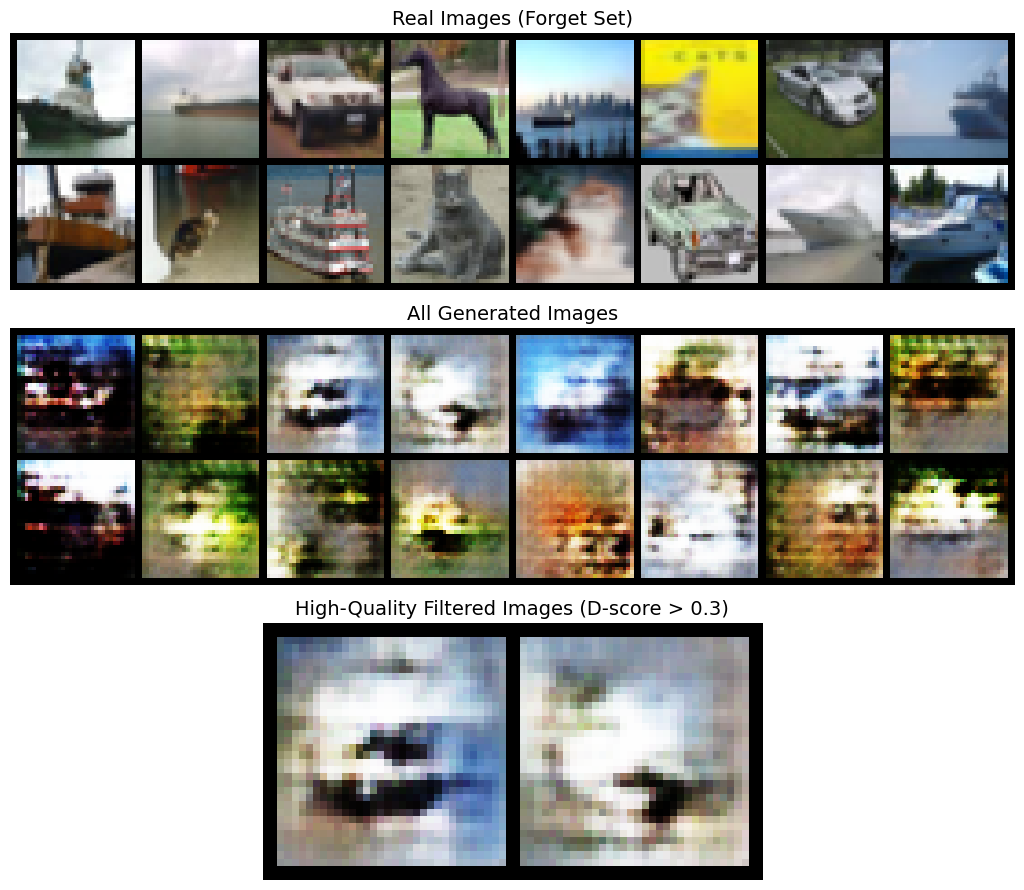

Discriminator Scores - Mean: 0.091, Std: 0.104
High-quality images (>0.3): 2/32
Comparison image saved to: ./real_vs_generated_filtered.png

========== Synthetic Data Quality Evaluation ===========
[Classification] Generated Synthetic Data Accuracy: 9.80% (24/245)

========== Final Results Summary ===========
Original Test Set Accuracy: 75.26%
Retain Set Accuracy: 96.86%
Forget Set Accuracy: 77.82%
Unseen Data Accuracy: 75.54%
Generated Synthetic Data Accuracy: 9.80%
MIA AUC (before unlearning): 0.4721

========== DCGAN Training Summary ===========
Forget dataset size: 3160
Generated images: 3160
High-quality filtered images: 245
Synthetic data quality (vs unseen): 65.74% gap


In [12]:
main()